In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load the dataset from csv files
full_dataset = pd.read_csv("../output_full_web_or_not.csv", header=0, usecols=[*range(1,23)], sep=";") 
full_dataset.dropna(axis = 0, inplace = True)
print("The shape of the full dataset: " + str(full_dataset.shape))

full_dataset.head()

# Set of features in the dataset
features = list(full_dataset.columns)
print("Features: " + str(features[:-1]))

The shape of the full dataset: (382, 22)
Features: ['session_time', '%tcp_protocol', '%udp_protocol', 'ul_data_volume', 'max_ul_volume', 'min_ul_volume', 'avg_ul_volume', 'std_ul_volume', '%ul_volume', 'dl_data_volume', 'max_dl_volume', 'min_dl_volume', 'avg_dl_volume', 'std_dl_volume', '%dl_volume', 'nb_uplink_packet', 'nb_downlink_packet', 'ul_packet', 'dl_packet', 'kB/s', 'nb_packet/s']


In [2]:
y_df = full_dataset['output'].to_frame()
X_df = full_dataset[full_dataset.columns.difference(['output'])]

X_train, X_test, y_train_orig, y_test_orig = train_test_split(X_df, y_df, train_size=0.7, random_state=1)

print("Shape of the training dataset: " + str(X_train.shape) + ", " + str(y_train_orig.shape))
print("Shape of the testing dataset: " + str(X_test.shape) + ", " + str(y_test_orig.shape))

print(X_train.index.tolist())

Shape of the training dataset: (267, 21), (267, 1)
Shape of the testing dataset: (115, 21), (115, 1)
[85, 58, 355, 231, 249, 171, 274, 131, 349, 325, 279, 210, 80, 88, 124, 229, 14, 253, 123, 111, 51, 112, 9, 221, 16, 322, 0, 105, 172, 235, 70, 38, 150, 225, 369, 145, 42, 313, 175, 207, 180, 383, 278, 176, 147, 257, 100, 34, 110, 334, 135, 365, 154, 19, 314, 158, 267, 44, 265, 254, 237, 108, 337, 169, 79, 370, 305, 8, 195, 99, 340, 321, 312, 28, 31, 55, 356, 32, 268, 48, 357, 275, 33, 374, 35, 361, 63, 157, 128, 46, 66, 378, 328, 245, 371, 381, 341, 45, 212, 168, 241, 47, 113, 178, 226, 297, 40, 21, 101, 164, 69, 53, 202, 290, 137, 24, 317, 188, 185, 211, 134, 294, 116, 219, 353, 142, 367, 335, 217, 258, 238, 300, 224, 56, 61, 307, 318, 284, 84, 182, 97, 114, 118, 293, 170, 338, 54, 177, 197, 201, 183, 103, 227, 130, 375, 60, 94, 196, 140, 148, 208, 152, 10, 276, 96, 216, 247, 57, 298, 36, 350, 20, 344, 75, 204, 77, 270, 384, 149, 343, 2, 52, 269, 260, 266, 184, 151, 354, 309, 193, 74,

In [3]:
from shapash import SmartExplainer
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(min_samples_leaf=2, random_state=0)
clf.fit(X_train, y_train_orig)
xpl = SmartExplainer(
    #preprocessing=encoder,
    model=clf,
    backend='shap',
    #data=X_train,     # Here we pass this optional parameter that is used by ACV
)
xpl.compile(x=X_test,
y_target=y_test_orig, # Optional: allows to display True Values vs Predicted Values
)

In [4]:
xpl.plot.features_importance()

In [5]:
xpl.plot.contribution_plot(col='%tcp_protocol')

In [6]:
app = xpl.run_app(title_story='User Network Activities Classification', port=8020)

Dash is running on http://0.0.0.0:8020/



INFO:root:Your Shapash application run on http://CHAMARA-XPS:8020/
INFO:shapash.webapp.smart_app:Dash is running on http://0.0.0.0:8020/

INFO:root:Use the method .kill() to down your app.


 * Serving Flask app "shapash.webapp.smart_app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://192.168.2.99:8020/ (Press CTRL+C to quit)


In [8]:
X_train[:10]

,%dl_volume,%tcp_protocol,%udp_protocol,%ul_volume,avg_dl_volume,avg_ul_volume,dl_data_volume,dl_packet,kB/s,max_dl_volume,...,min_dl_volume,min_ul_volume,nb_downlink_packet,nb_packet/s,nb_uplink_packet,session_time,std_dl_volume,std_ul_volume,ul_data_volume,ul_packet
85,97.724634,99.740597,0.259403,2.275366,1582.848420,55.701412,2203325,60.181582,451.069179,5894,...,60.0,54,1392,462.747707,921,4.998404,428.148576,21.729035,51301,39.818418
58,98.076732,99.954559,0.045441,1.923268,1601.515144,54.640249,6715153,63.501439,1374.343115,10274,...,60.0,54,4193,1325.398708,2410,4.981897,676.684743,13.466270,131683,36.498561
355,98.379010,8.447937,91.552063,1.620990,1260.195900,130.221429,1106452,86.247544,502.260783,1514,...,60.0,54,878,454.618303,140,2.239241,198.792995,137.189889,18231,13.752456
231,96.163313,99.613153,0.386847,3.836687,1166.034483,55.105634,980635,54.223082,687.586730,7446,...,60.0,54,841,1045.782359,710,1.483100,599.172902,17.090610,39125,45.776918
249,95.621918,99.519808,0.480192,4.378082,1174.780660,55.760391,498107,50.900360,777.308017,9558,...,60.0,54,424,1243.005220,409,0.670150,686.278746,21.943026,22806,49.099640
171,86.248583,100.000000,0.000000,13.751417,456.600000,91.000000,2283,55.555556,0.927206,1466,...,74.0,74,5,3.152572,4,2.854812,583.000686,19.697716,364,44.444444
274,99.160430,98.765432,1.234568,0.839570,5658.653631,59.144828,1012899,55.246914,1773.569628,40934,...,60.0,54,179,562.555676,145,0.575943,5137.061397,37.474061,8576,44.753086
131,95.505974,89.333333,10.666667,4.494026,2035.000000,93.236842,75295,49.333333,386.818841,16758,...,60.0,54,37,367.987684,38,0.203811,3567.301867,97.502165,3543,50.666667
349,76.947426,14.285714,85.714286,23.052574,729.260870,314.062500,117411,58.974359,30.895897,1466,...,74.0,74,161,55.277548,112,4.938714,563.314061,405.058494,35175,41.025641
325,97.357167,97.790055,2.209945,2.642833,2138.574468,62.724138,201026,51.933702,427.408170,40934,...,60.0,54,94,374.659796,87,0.483105,4468.041589,48.820433,5457,48.066298


In [9]:
from shapash.explainer.consistency import Consistency
cns = Consistency()
cns.compile(x=X_train[:10], # Dataset for which we need explanations
            model=clf, # Model to explain
            #preprocessing=encoder, # Optional
            )

 60%|██████    | 6/10 [00:00<00:00, 20.34it/s]


In [11]:
cns.consistency_plot(max_features=21)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [12]:
# index = X_test.index.tolist() -> error index out of bound ?
index = [1, 2, 3, 4, 5]
cns.consistency_plot(selection=index, max_features=21)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [13]:
import shap

treeSHAP = shap.TreeExplainer(clf).shap_values(X_train, check_additivity=False)[1]
samplingSHAP = shap.SamplingExplainer(clf.predict_proba, shap.kmeans(X_train, 200)).shap_values(X_train, check_additivity=False)[1]
kernelSHAP = shap.KernelExplainer(clf.predict_proba, shap.kmeans(X_train, 200)).shap_values(X_train, check_additivity=False)[1]

treeSHAP = pd.DataFrame(treeSHAP, columns=X_train.columns)
samplingSHAP = pd.DataFrame(samplingSHAP, columns=X_train.columns)
kernelSHAP = pd.DataFrame(kernelSHAP, columns=X_train.columns)

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0.09746061 0.0956886 ]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 0.00396673  0.03860388  0.02976868  0.0003182   0.01350811  0.01378277
 -0.0003576   0.00600104  0.00380237  0.03094124  0.00175042 -0.00067784
  0.00091778 -0.00130212  0.00010681  0.00412174 -0.00076501  0.04356689
  0.00411347  0.00291535  0.00553095]
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-0.00396673 -0.03860388 -0.02976868 -0.0003182  -0.01350811 -0.01378277
  0.0003576  -0.00600104 -0.00380237 -0.03094124 -0.00175042  0.00067784
 -0.00091778  0.00130212 -0.00010681 -0.00412174  0.00076501 -0.04356689
 -0.00411347 -0.00291535 -0.00553095]
INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = 

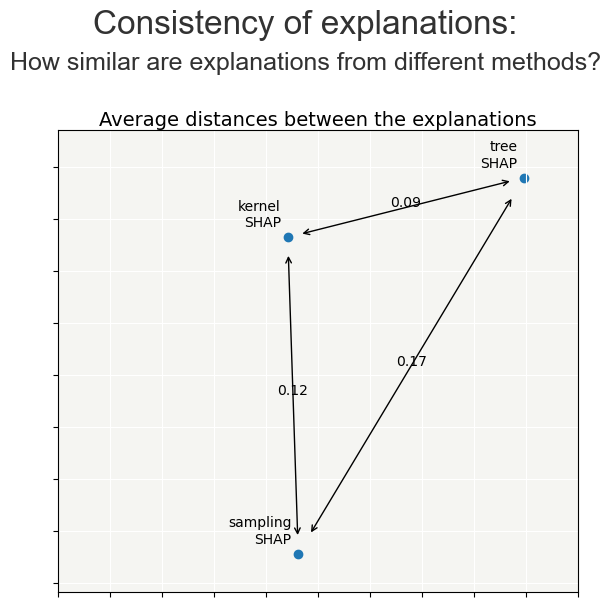

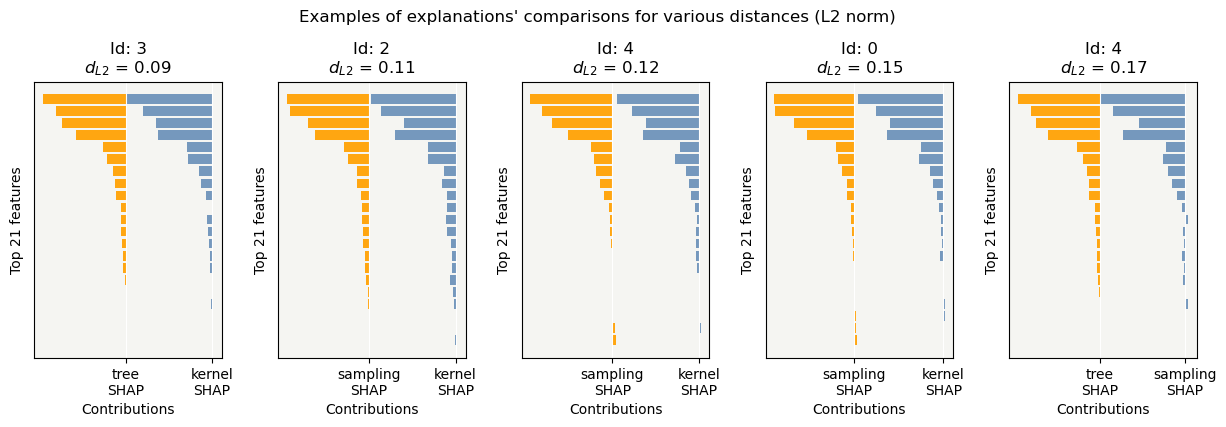

In [14]:
# The format must be a dictionary where keys are methods names and values are pandas DataFrames: be careful to have dataframes with same shape, index and column names
contributions = {"tree\nSHAP": treeSHAP, "sampling\nSHAP": samplingSHAP, "kernel\nSHAP":kernelSHAP}

index = [45, 36, 12, 17, 29]
cns = Consistency()
cns.compile(contributions=contributions,
            x=X_train[:50] #Optionnal, needed to display pairwise_consistency_plot
           )
cns.consistency_plot(selection=index, max_features=21)

In [15]:
response_dict = {1: 'Web', 2: 'Not Web'}
features = list(full_dataset.columns)
features_dict = dict(zip(features, features))
xpl = SmartExplainer(
    model=clf, 
    #preprocessing=encoder, 
    features_dict=features_dict, # Optional parameters
    label_dict=response_dict    # Optional parameters, dicts specify labels 
)
xpl.compile(x=X_train)
xpl.plot.compacity_plot()

In [16]:
index = [0, 1, 2]

xpl.plot.compacity_plot(selection=index, approx=.85, nb_features=3)

In [17]:
xpl.plot.stability_plot()

In [18]:
index = [1, 2, 3, 8, 9]

# Using distribution = "boxplot" or "violin" displays distributions of variability instead of means
xpl.plot.stability_plot(selection=index, max_features=5, distribution="boxplot")

In [19]:
xpl.plot.local_neighbors_plot(index=1)